<a href="https://colab.research.google.com/github/MEE-SPT/MEE-SPT/blob/main/Automated_apple_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
from scipy import ndimage # multidimensional image processing
from skimage.color import rgb2hsv, hsv2rgb # image processing algorithms
import matplotlib.pyplot as plt
import math

In [ ]:
def counting_apple(img):

    # resize image
    img = cv2.resize(img, (320,320))

    # convert to RGB img
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # deep copy image
    ori_img = img_rgb.copy()  
    
    # image contrast enhancment
    alpha = 1.4 # Contrast control (1.0-3.0)
    beta = -50 # Brightness control (0-100)
    img = adjustContrastBrightness(img, alpha, beta)

    # convert to RGB img
    #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # convert to HSV format
    hsv_img = rgb2hsv(img_rgb)
    
    # get equalized image
    equ_img = equalizedImage(hsv_img)

    # split green channel image
    _,g,_ = cv2.split(img_rgb)

    # subtract green channel from equalized image
    green_subs = cv2.subtract(equ_img,(g).astype(np.uint8))

    # convert to binary image using otsu
    _, binary_img = cv2.threshold(green_subs, thresh=127, maxval=255, type=cv2.THRESH_OTSU)
    
    # segment image
    segmented_img = imageSegment(binary_img)
    
    # count apple
    n_apples, final_img = countAndLabel(segmented_img, ori_img)

    return n_apples, final_img 

In [ ]:
def adjustContrastBrightness(img, alpha, beta):

    adjusted_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    
    return adjusted_img

In [ ]:
def equalizedImage(hsv_img):

    #Separate into channels
    hue_img = hsv_img[:,:,0]
    sat_img = hsv_img[:,:,1]
    val_img = hsv_img[:,:,2]

    # rescale from 0-1 to 0-255
    hsv_c = (255*val_img).astype(np.uint8) 

    # equalize value to improve 
    equ = cv2.equalizeHist(hsv_c)
    
    return equ

In [ ]:
def imageSegment(img):

    # create kernel
    e_kernel = np.ones((5,5),np.uint8)
    d_kernel = np.ones((3,3),np.uint8)
    e2_kernel = np.ones((3,3),np.uint8)

    # erode and dilate
    img = cv2.erode(img, e_kernel,iterations = 6)
    img = cv2.dilate(img, d_kernel,iterations = 4)
    img = cv2.erode(img, e2_kernel,iterations = 8)

    return img

In [ ]:
def filDist(centroid, distance):
    """
    This function used to discard the blobs, 
    if that blobs' centroid are close to other blobs less than the distance setting
    """
    n = len(centroid)

    too_close_cen = []
    for i in range(n):
      x0 = centroid[i][0]
      y0 = centroid[i][1]

      x = np.arange(i,n)

      for j in x:
        x1 = centroid[j][0]
        y1 = centroid[j][1]
        
        x_dist = x1-x0
        y_dist = y1-y0 
        dist = math.sqrt(x_dist**2+y_dist**2)
        if i != j:
          if dist <= distance:
            posi = [i,j]
            too_close_cen.append(posi)

    dup_cen = []
    for posi in too_close_cen:
        posi_0 = posi[0]
        posi_1 = posi[1]
        if posi_0 in dup_cen:
          pass
        else:
          dup_cen.append(posi_1)

    use_idx = []
    for idx in range(n):
      if idx not in dup_cen:
        use_idx.append(idx)

    return use_idx

In [ ]:
def countAndLabel(img, ori_img):

    # Label features in an array. Any non-zero values in input are counted as features and zero values are considered the background.
    labels, nlabels = ndimage.label(img)  

    centroid = ndimage.center_of_mass(img, labels, np.arange(nlabels) + 1 ) # calculate the center of mass of the values of an array at labels.
    
    fil_idx = filDist(centroid, 50)

    nlabels = len(fil_idx)

    # draw circles representing the centroids
    for idx in fil_idx:
      cen  = centroid[idx]
      ori_img = cv2.circle(ori_img, (cen[1].astype(int), cen[0].astype(int)), radius=20, color=(0, 255, 255), thickness=2)

    return nlabels, ori_img

In [ ]:
def hsvRedSegmentation(img_hsv):
  # create range for red color range hsv
  lower_red = np.array([150,50,50])
  upper_red = np.array([180,255,255])

  # create picture from red color filter
  red_mask = cv2.inRange(img_hsv, lower_red, upper_red)

  return red_mask

3
2
2
6
4
4
3
2
3
0
2
3
4
3
2
2
4
3
2
1


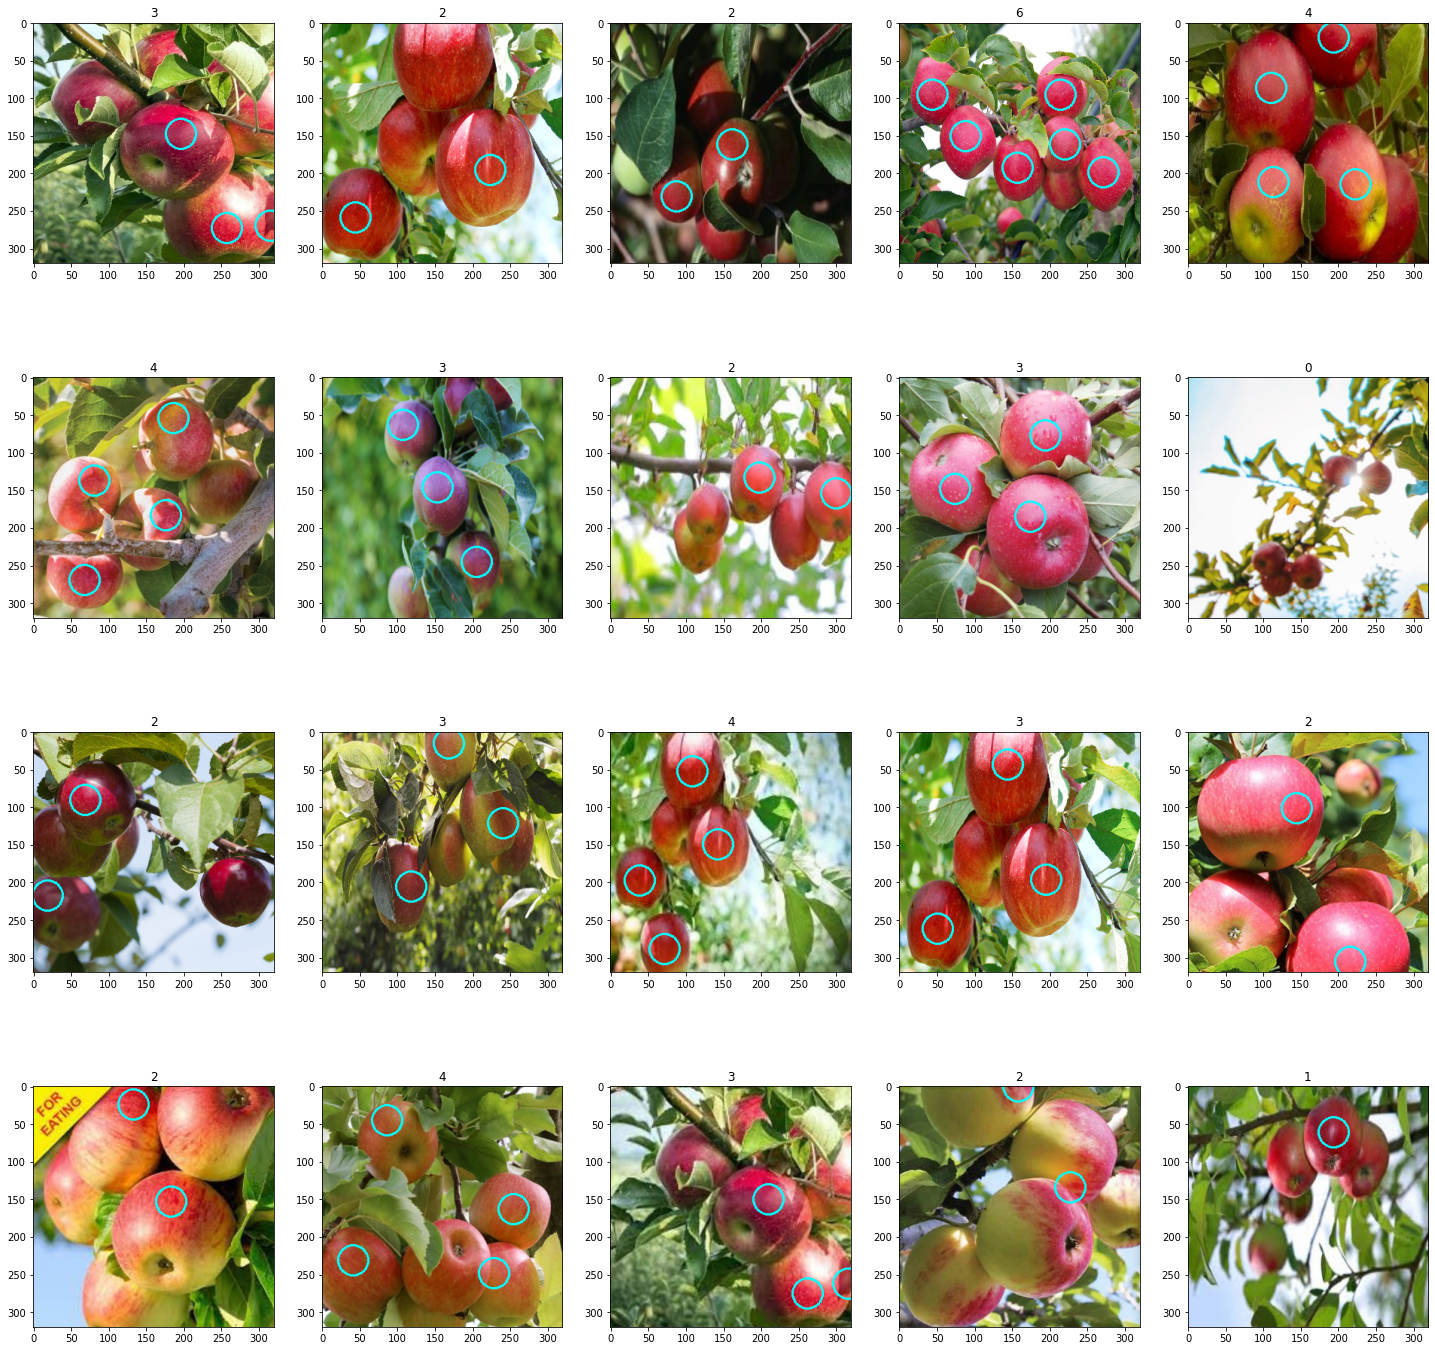

In [ ]:
# import required module
import os
# assign directory
folder_path = '/content/drive/MyDrive/dataset/image/five_apple'
 
# iterate over files in
# that directory
n_apples_list = []
img_list = []

for filename in os.listdir(folder_path):
    dir = os.path.join(folder_path, filename)
    img = cv2.imread(dir)

    n_apples, img = counting_apple(img)
    n_apples_list.append(n_apples)
    img_list.append(img)

row = math.ceil(len(n_apples_list)/5)
for i in range(len(n_apples_list)):
    print(n_apples_list[i])
    
    plt.figure(1, figsize=(25,25))
    plt.subplot(row,5,(i+1))
    plt.title(n_apples_list[i])
    plt.imshow(img_list[i])
    